In [17]:
import IPython.display as ipd
ipd.Audio('./UrbanSound8K/audio/fold1/102106-3-0-0.wav')

In [3]:
import librosa
from librosa import display

In [18]:
data, sampling_rate = librosa.load('./UrbanSound8K/audio/fold1/102106-3-0-0.wav')

Populating the interactive namespace from numpy and matplotlib


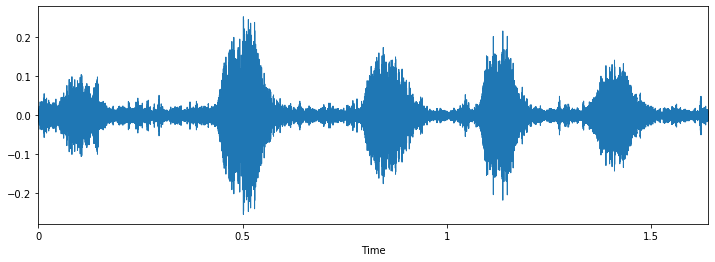

In [19]:
%pylab inline
import os
import pandas as pd
import glob 

plt.figure(figsize=(12, 4))
librosa.display.waveplot(data, sr=sampling_rate)

In [22]:
n = librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=40)

### Medium

In [3]:
# Load various imports 
import pandas as pd
import os
import librosa
import librosa.display

In [8]:
from tqdm import tqdm

In [12]:
import numpy as np

In [1]:
import struct

class WavFileHelper():
    
    def read_file_properties(self, filename):

        wave_file = open(filename,"rb")
        
        riff = wave_file.read(12)
        fmt = wave_file.read(36)
        
        num_channels_string = fmt[10:12]
        num_channels = struct.unpack('<H', num_channels_string)[0]

        sample_rate_string = fmt[12:16]
        sample_rate = struct.unpack("<I",sample_rate_string)[0]
        
        bit_depth_string = fmt[22:24]
        bit_depth = struct.unpack("<H",bit_depth_string)[0]

        return (num_channels, sample_rate, bit_depth)

In [4]:
metadata = pd.read_csv("./UrbanSound1K/metadata/UrbanSound1K.csv")

In [9]:
#from helpers.wavfilehelper import WavFileHelper
wavfilehelper = WavFileHelper()

audiodata = []
for index, row in tqdm(metadata.iterrows()):
    
    file_name = os.path.join(os.path.abspath('./UrbanSound8K/audio/'),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    data = wavfilehelper.read_file_properties(file_name)
    audiodata.append(data)

# Convert into a Panda dataframe
audiodf = pd.DataFrame(audiodata, columns=['num_channels','sample_rate','bit_depth'])

873it [00:22, 38.59it/s]


In [14]:
def extract_features(file_name):
   
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccsscaled = np.mean(mfccs.T,axis=0)
        
    except Exception as e:
        print("Error encountered while parsing file: ", file)
        return None 
     
    return mfccsscaled
    
    
# Load various imports 
import pandas as pd
import os
import librosa

# Set the path to the full UrbanSound dataset 
fulldatasetpath = './UrbanSound1K/audio/'

metadata = pd.read_csv(fulldatasetpath + '../metadata/UrbanSound1K.csv')

features = []

# Iterate through each sound file and extract the features 
for index, row in tqdm(metadata.iterrows()):
    
    file_name = os.path.join(os.path.abspath(fulldatasetpath),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    
    class_label = row["class"]
    data = extract_features(file_name)
    
    features.append([data, class_label])

# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

print('Finished feature extraction from ', len(featuresdf), ' files')

873it [02:26,  5.97it/s]


Finished feature extraction from  873  files


In [28]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 

# split the dataset 
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)

Using TensorFlow backend.


In [31]:
x_train.shape

(698, 40)

In [35]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

num_labels = yy.shape[1]
filter_size = 2

# Construct model 
model = Sequential()

model.add(Dense(256, input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [36]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy) 

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 256)               10496     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)               

In [38]:
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 

num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.basic_mlp.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Train on 698 samples, validate on 175 samples
Epoch 1/100
698/698 [==============================] - ETA: 0s - loss: 12.8967 - accuracy: 0.312 - ETA: 0s - loss: 18.8171 - accuracy: 0.226 - ETA: 0s - loss: 18.1842 - accuracy: 0.250 - ETA: 0s - loss: 17.8344 - accuracy: 0.268 - ETA: 0s - loss: 17.4028 - accuracy: 0.267 - ETA: 0s - loss: 17.0546 - accuracy: 0.267 - 0s 620us/step - loss: 17.0016 - accuracy: 0.2693 - val_loss: 3.6049 - val_accuracy: 0.3600

Epoch 00001: val_loss improved from inf to 3.60486, saving model to saved_models/weights.best.basic_mlp.hdf5
Epoch 2/100
698/698 [==============================] - ETA: 0s - loss: 14.5634 - accuracy: 0.312 - ETA: 0s - loss: 13.6398 - accuracy: 0.260 - ETA: 0s - loss: 13.2695 - accuracy: 0.236 - ETA: 0s - loss: 12.1463 - accuracy: 0.250 - ETA: 0s - loss: 11.9088 - accuracy: 0.252 - ETA: 0s - loss: 11.7401 - accuracy: 0.250 - ETA: 0s - loss: 11.5619 - accuracy: 0.256 - ETA: 0s - loss: 10.9661 - accuracy: 0.258 - 1s 724us/step - loss: 10.42

698/698 [==============================] - ETA: 1s - loss: 1.4768 - accuracy: 0.50 - ETA: 0s - loss: 1.3884 - accuracy: 0.53 - ETA: 0s - loss: 1.4021 - accuracy: 0.51 - ETA: 0s - loss: 1.3465 - accuracy: 0.53 - ETA: 0s - loss: 1.3780 - accuracy: 0.51 - ETA: 0s - loss: 1.3973 - accuracy: 0.50 - ETA: 0s - loss: 1.4031 - accuracy: 0.51 - ETA: 0s - loss: 1.4000 - accuracy: 0.51 - ETA: 0s - loss: 1.4188 - accuracy: 0.50 - ETA: 0s - loss: 1.4148 - accuracy: 0.51 - 1s 964us/step - loss: 1.4114 - accuracy: 0.5115 - val_loss: 1.2184 - val_accuracy: 0.6571

Epoch 00025: val_loss improved from 1.30555 to 1.21840, saving model to saved_models/weights.best.basic_mlp.hdf5
Epoch 26/100
698/698 [==============================] - ETA: 0s - loss: 1.0931 - accuracy: 0.65 - ETA: 0s - loss: 1.2038 - accuracy: 0.55 - ETA: 0s - loss: 1.1961 - accuracy: 0.56 - ETA: 0s - loss: 1.2457 - accuracy: 0.54 - ETA: 0s - loss: 1.2680 - accuracy: 0.53 - ETA: 0s - loss: 1.2606 - accuracy: 0.54 - ETA: 0s - loss: 1.2767 - 

698/698 [==============================] - ETA: 0s - loss: 0.7205 - accuracy: 0.75 - ETA: 0s - loss: 0.8280 - accuracy: 0.71 - ETA: 0s - loss: 0.8153 - accuracy: 0.70 - ETA: 0s - loss: 0.8369 - accuracy: 0.71 - ETA: 0s - loss: 0.8290 - accuracy: 0.71 - ETA: 0s - loss: 0.8082 - accuracy: 0.71 - ETA: 0s - loss: 0.8068 - accuracy: 0.71 - ETA: 0s - loss: 0.8064 - accuracy: 0.71 - ETA: 0s - loss: 0.8088 - accuracy: 0.71 - ETA: 0s - loss: 0.8192 - accuracy: 0.71 - ETA: 0s - loss: 0.8232 - accuracy: 0.71 - ETA: 0s - loss: 0.8294 - accuracy: 0.71 - ETA: 0s - loss: 0.8358 - accuracy: 0.71 - 1s 2ms/step - loss: 0.8379 - accuracy: 0.7092 - val_loss: 0.6329 - val_accuracy: 0.8229

Epoch 00045: val_loss improved from 0.67917 to 0.63287, saving model to saved_models/weights.best.basic_mlp.hdf5
Epoch 46/100
698/698 [==============================] - ETA: 1s - loss: 0.9582 - accuracy: 0.59 - ETA: 1s - loss: 1.0332 - accuracy: 0.59 - ETA: 1s - loss: 0.9883 - accuracy: 0.59 - ETA: 1s - loss: 0.8903 - ac


Epoch 00064: val_loss did not improve from 0.43587
Epoch 65/100
698/698 [==============================] - ETA: 0s - loss: 0.4885 - accuracy: 0.81 - ETA: 1s - loss: 0.5263 - accuracy: 0.73 - ETA: 0s - loss: 0.3991 - accuracy: 0.79 - ETA: 0s - loss: 0.4511 - accuracy: 0.79 - ETA: 0s - loss: 0.4690 - accuracy: 0.79 - ETA: 0s - loss: 0.4298 - accuracy: 0.81 - ETA: 0s - loss: 0.4344 - accuracy: 0.81 - ETA: 0s - loss: 0.4091 - accuracy: 0.83 - ETA: 0s - loss: 0.4033 - accuracy: 0.83 - ETA: 0s - loss: 0.4199 - accuracy: 0.83 - ETA: 0s - loss: 0.4096 - accuracy: 0.83 - ETA: 0s - loss: 0.4276 - accuracy: 0.83 - ETA: 0s - loss: 0.4384 - accuracy: 0.82 - ETA: 0s - loss: 0.4529 - accuracy: 0.82 - ETA: 0s - loss: 0.4496 - accuracy: 0.83 - 1s 2ms/step - loss: 0.4528 - accuracy: 0.8338 - val_loss: 0.4366 - val_accuracy: 0.9029

Epoch 00065: val_loss did not improve from 0.43587
Epoch 66/100
698/698 [==============================] - ETA: 1s - loss: 0.5348 - accuracy: 0.75 - ETA: 1s - loss: 0.4649 -

Epoch 00083: val_loss improved from 0.34976 to 0.33708, saving model to saved_models/weights.best.basic_mlp.hdf5
Epoch 84/100
698/698 [==============================] - ETA: 0s - loss: 0.4539 - accuracy: 0.81 - ETA: 0s - loss: 0.4024 - accuracy: 0.85 - ETA: 0s - loss: 0.4019 - accuracy: 0.85 - ETA: 0s - loss: 0.3569 - accuracy: 0.86 - ETA: 0s - loss: 0.3668 - accuracy: 0.85 - ETA: 0s - loss: 0.3447 - accuracy: 0.86 - ETA: 0s - loss: 0.3343 - accuracy: 0.87 - ETA: 0s - loss: 0.3468 - accuracy: 0.86 - ETA: 0s - loss: 0.3347 - accuracy: 0.87 - ETA: 0s - loss: 0.3212 - accuracy: 0.88 - ETA: 0s - loss: 0.3155 - accuracy: 0.88 - ETA: 0s - loss: 0.3293 - accuracy: 0.87 - ETA: 0s - loss: 0.3375 - accuracy: 0.87 - ETA: 0s - loss: 0.3367 - accuracy: 0.87 - ETA: 0s - loss: 0.3401 - accuracy: 0.87 - 1s 2ms/step - loss: 0.3414 - accuracy: 0.8768 - val_loss: 0.3513 - val_accuracy: 0.9086

Epoch 00084: val_loss did not improve from 0.33708
Epoch 85/100
698/698 [==============================] - ETA: 

In [39]:

# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9785100221633911
Testing Accuracy:  0.9028571248054504
